# $\textit{Embeddings}$

In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

tnews = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'))

In [50]:
#pprint(tnews.keys())
#pprint(tnews.target_names)
#pprint(tnews.target)
#pprint(tnews.target.shape)
#pprint(tnews.filenames.shape)
#pprint(tnews.data[1])

$\textit{TFIDF/CV - Matriz DT}$

In [10]:
tfidf1 = TfidfVectorizer(ngram_range=(1,1), stop_words="english")
tfidf2 = TfidfVectorizer(ngram_range=(1,2), stop_words="english")
cv1 = CountVectorizer(ngram_range=(1,1), stop_words="english")
cv2 = CountVectorizer(ngram_range=(1,2), stop_words="english")

vectorization1 = tfidf1.fit_transform(tnews.data)
vocabulary1 = tfidf1.get_feature_names_out()
vectorization2 = tfidf2.fit_transform(tnews.data)
vocabulary2 = tfidf2.get_feature_names_out()

vectorization3 = cv1.fit_transform(tnews.data)
vocabulary3 = cv1.get_feature_names_out()
vectorization4 = cv2.fit_transform(tnews.data)
vocabulary4 = cv2.get_feature_names_out()

Las vectorizaciones devuelven para cada fila (un documento) la repeticion de cada termino del vocabulario

In [51]:
#pprint(vectorization1)
#pprint(vocabulary1[17000:17010])
#print(vectorization3[:2]) #Agarro los primeros 2 documentos y sus repeticiones de terminos
#print(vocabulary1[25717])

Similitud coseno entre los primeros 10 documentos del corpus representados como vectores CV o TFIDF

<Axes: >

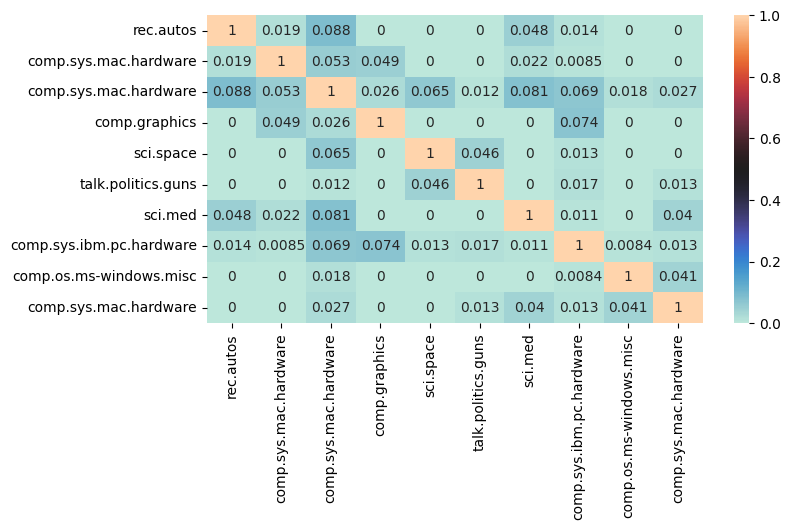

In [12]:
matTest = cosine_similarity(vectorization3[:10])

names = [tnews.target_names[i] for i in tnews.target[:10]]

fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(matTest, annot=True, 
            xticklabels=names,
            yticklabels=names,
            ax=ax,
            cmap="icefire")

Lo mismo que antes pero vemos las diferencias entre CV y TFIDF

<Axes: >

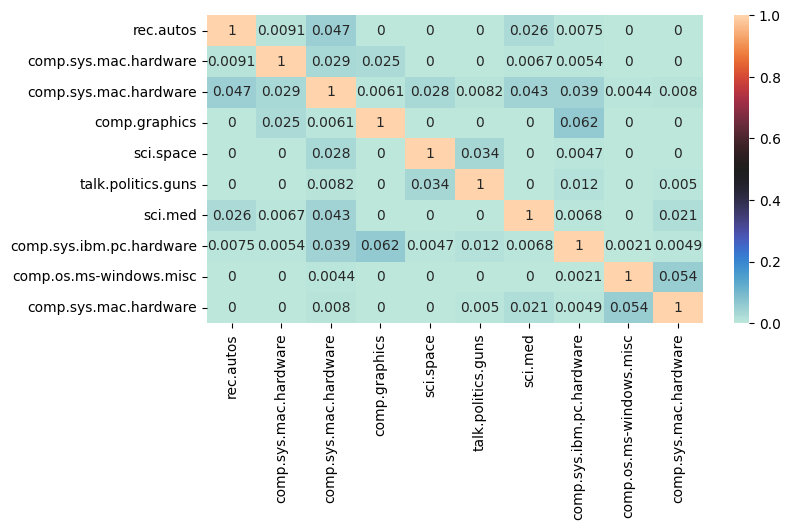

In [13]:
matTest = cosine_similarity(vectorization1[:10])

names = [tnews.target_names[i] for i in tnews.target[:10]]

fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(matTest, annot=True, 
            xticklabels=names,
            yticklabels=names,
            ax=ax,
            cmap="icefire")

In [14]:
def getSimilarity(vectors, ref, quant=None):
    
    matriz_similaridad = cosine_similarity(vectors)

    # Create a generator to yield category articles on-the-fly
    def category_articles_generator():
        for i, category in enumerate(tnews.target_names):
            category_indices = [j for j in range(len(tnews.data)) if tnews.target[j] == i]
            yield category, category_indices

    articles_ref = []
    articles_diff = set(range(1, len(tnews.target)+1))

    for category, article_indices in category_articles_generator():
        if category == ref:
            articles_ref.extend(article_indices)
            articles_diff.difference_update(article_indices)

    reference_article = random.choice(articles_ref)

    # Calculate similarities using generators
    def similarity_generator(artNum):
        vals = []
        for artIx in artNum:
            if artIx != reference_article:
                vals.append(matriz_similaridad[reference_article, artIx-1])
        return vals

    same = similarity_generator(articles_ref)
    diff = similarity_generator(articles_diff)

    return same, diff

same1, diff1 = getSimilarity(vectorization1, 'sci.space')
same2, diff2 = getSimilarity(vectorization2, 'sci.space')
same3, diff3 = getSimilarity(vectorization3, 'sci.space')
same4, diff4 = getSimilarity(vectorization4, 'sci.space')

In [15]:
def histComp(docs1, docs2, text1, text2):
    
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

    plt.subplot(2, 2, 1)
    plt.hist(list(docs1), edgecolor='black', bins=20, density=True, log=False)
    plt.xlabel('SimCos')
    plt.ylabel('Frequency')
    plt.title(text1)

    plt.subplot(2, 2, 2)
    plt.hist(list(docs2), edgecolor='black', bins=20, density=True, log=False)
    plt.xlabel('SimCos')
    plt.ylabel('Frequency')
    plt.title(text2)

    plt.show()

Como es de esperar, los articulos de otras categorias tienen menos similitud coseno que los articulos del mismo tipo. 

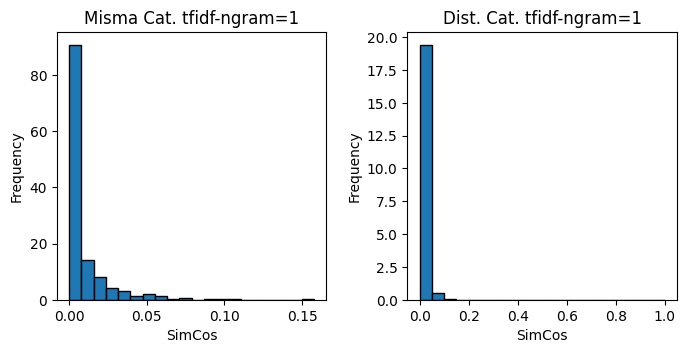

In [16]:
histComp(same1, diff1, 'Misma Cat. tfidf-ngram=1', 'Dist. Cat. tfidf-ngram=1')

Como la vectorizacion TFIDF penaliza las palabras que aparecen muchas veces en el corpus, se interpreta que los resultados son los esperados, ya que la similitud coseno entre los documentos de la misma categoria usando este metodo son menor en comparacion a la vectorizacion CV.

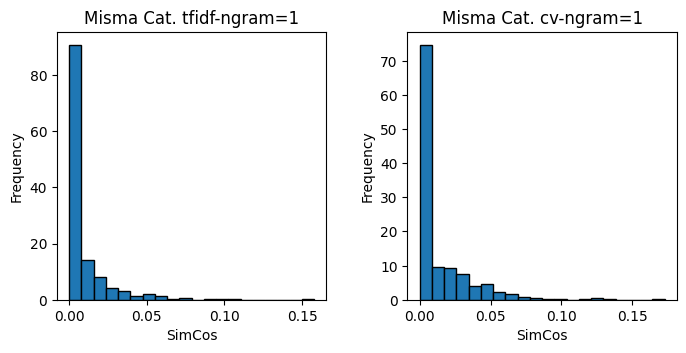

In [17]:
histComp(same1, same3, 'Misma Cat. tfidf-ngram=1', 'Misma Cat. cv-ngram=1')

Se observo que al agrandar los n_gramas de 1 a 1 y 2, la similitud entre textos de del mismo tipo es mayor.

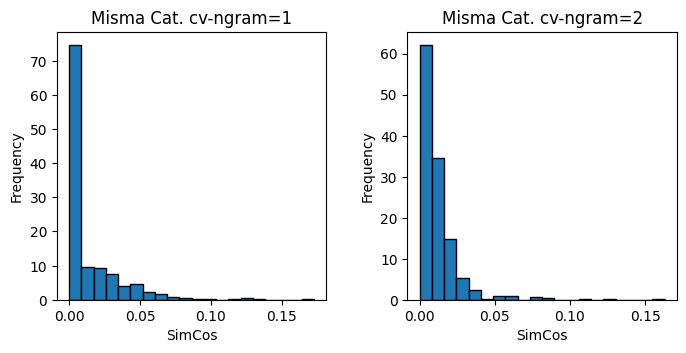

In [18]:
histComp(same3, same4, 'Misma Cat. cv-ngram=1', 'Misma Cat. cv-ngram=2')

Contrariamente, se observo que al agrandar los n_gramas de 1 a 1 y 2, la similitud entre textos de distinto tipo es menor.

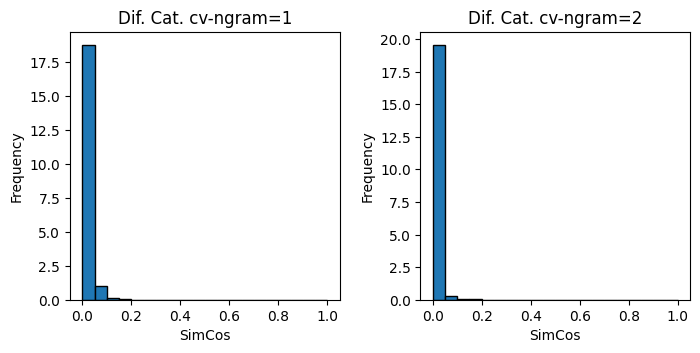

In [19]:
histComp(diff3, diff4, 'Dif. Cat. cv-ngram=1', 'Dif. Cat. cv-ngram=2')

$\textit{Ahora con TSVD}$

Generamos con TSVD una representacion en baja dimensionalidad de los vectores que representan a los documentos

In [20]:
svd = TruncatedSVD(n_components=32)
svd.fit(vectorization1)
transformed = svd.transform(vectorization1)
transformed.shape

(11314, 32)

Se observa en el heatmap que en esta nueva representacion existen documentos que claramente se asemejan mas entre ellos (como un documento de comp.sys.mac.hardware con otro de la misma categoria) y documentos que parecerian a tender a ser opuestos (como sci.space y comp.graphics).

<Axes: >

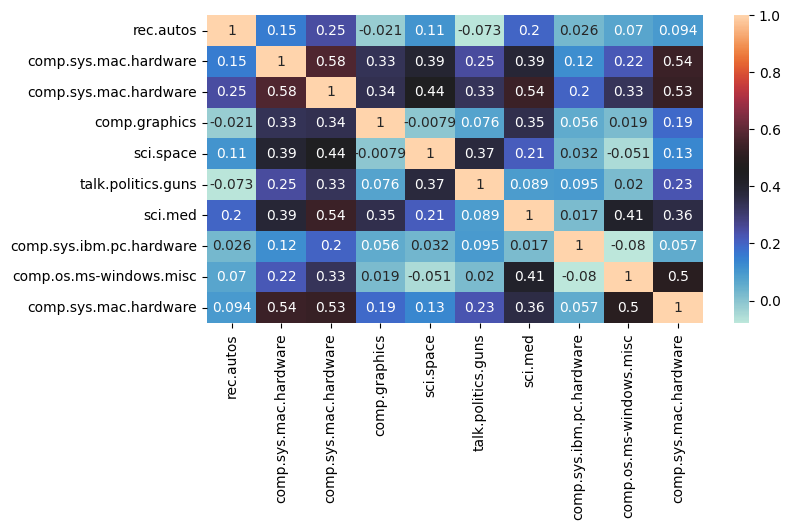

In [21]:
mat = cosine_similarity(transformed[:10])

names = [tnews.target_names[i] for i in tnews.target[:10]]

fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(mat, annot=True, 
            xticklabels=names,
            yticklabels=names,
            ax=ax,
            cmap="icefire")

In [22]:
same1svd, diff1svd = getSimilarity(transformed, 'sci.space')
same2svd, diff2svd = getSimilarity(transformed, 'sci.space')
same3svd, diff3svd = getSimilarity(transformed, 'sci.space')
same4svd, diff4svd = getSimilarity(transformed, 'sci.space')

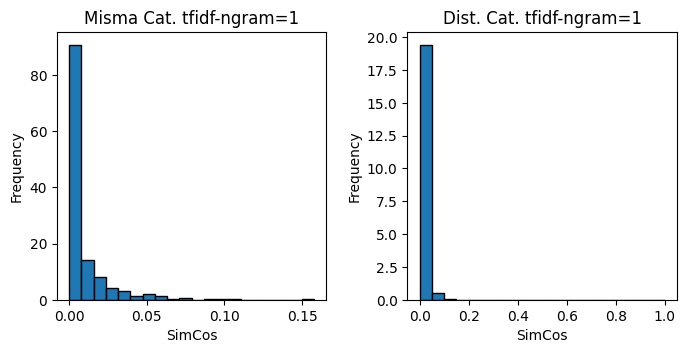

In [23]:
histComp(same1, diff1, 'Misma Cat. tfidf-ngram=1', 'Dist. Cat. tfidf-ngram=1')

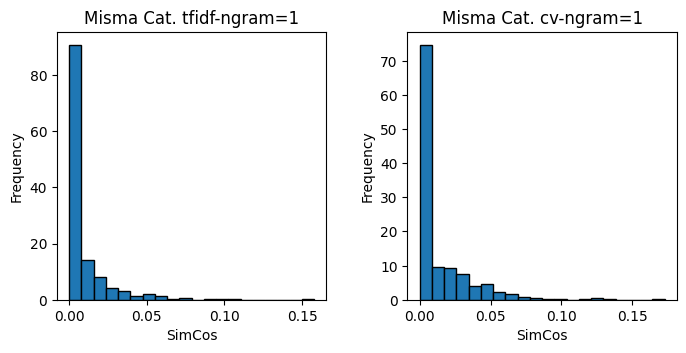

In [24]:
histComp(same1, same3, 'Misma Cat. tfidf-ngram=1', 'Misma Cat. cv-ngram=1')

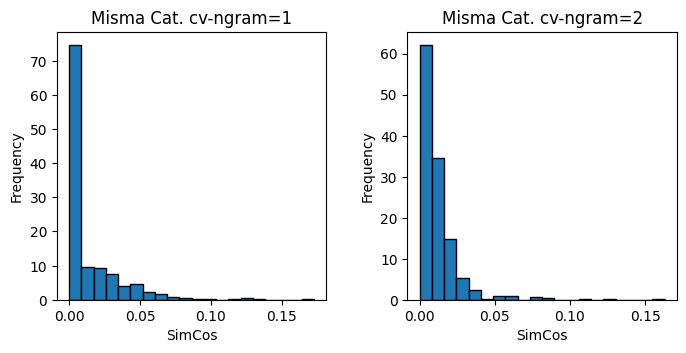

In [25]:
histComp(same3, same4, 'Misma Cat. cv-ngram=1', 'Misma Cat. cv-ngram=2')

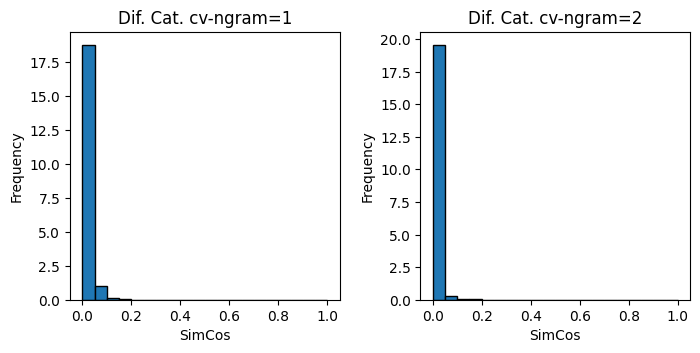

In [26]:
histComp(diff3, diff4, 'Dif. Cat. cv-ngram=1', 'Dif. Cat. cv-ngram=2')

$\textit{Matriz TD}$

In [27]:
termDocMat = vectorization1.transpose()
termDocMat

<101322x11314 sparse matrix of type '<class 'numpy.float64'>'
	with 755809 stored elements in Compressed Sparse Column format>

Se observa como es de esperar que palabras similares tiene una similitud coseno mayor que aquellas menos relacionadas

<Axes: >

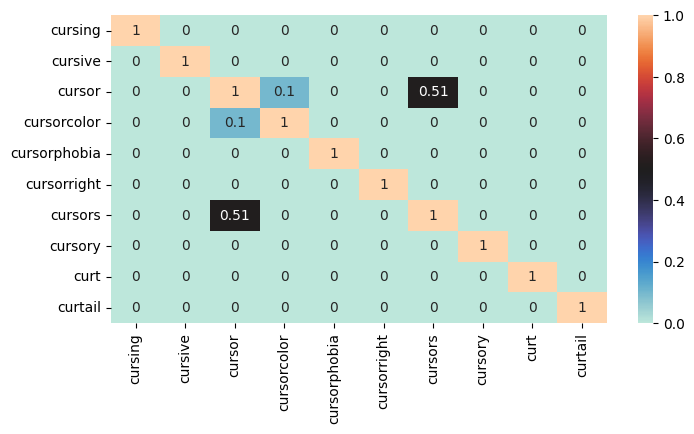

In [28]:
fromI = 31000

matTermDocSim = cosine_similarity(termDocMat[fromI:fromI+10])

names = vocabulary1[fromI:fromI+10]

fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(matTermDocSim, annot=True, 
            xticklabels=names,
            yticklabels=names,
            ax=ax,
            cmap="icefire")

$\textit{Matriz TC}$

In [29]:
# Create a term-class sparse matrix
from scipy.sparse import lil_matrix, coo_matrix

termClassMat = lil_matrix((len(vocabulary3), len(tnews.target_names)), dtype=np.float32)
cx = coo_matrix(vectorization3)

# Populate the term-class matrix
for i,j,v in zip(cx.row, cx.col, cx.data):
    class_i = tnews.target[i]
    termClassMat[j, class_i] += v


Obtenemos una representacion de cada termino en funcion de los documentos

<Axes: >

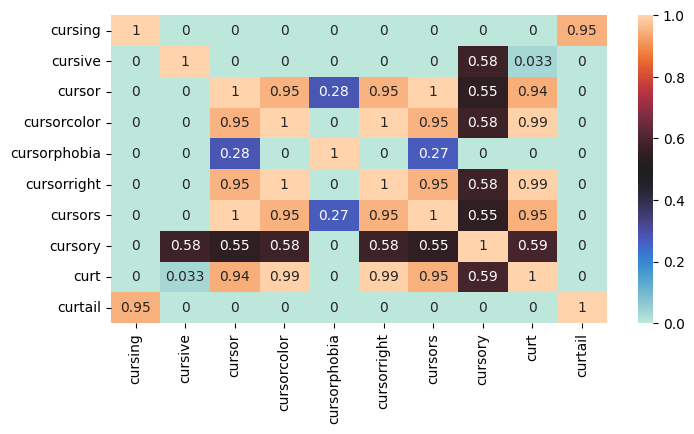

In [30]:
fromI = 31000

matTermClassSim = cosine_similarity(termClassMat[fromI:fromI+10])
names = vocabulary3[fromI:fromI+10]

fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(matTermClassSim, annot=True, 
            xticklabels=names,
            yticklabels=names,
            ax=ax,
            cmap="icefire")

$\textit{Matriz TT}$

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import make_sampling_table, skipgrams

In [32]:
token = Tokenizer(
    num_words=10000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None
)

token.fit_on_texts(tnews.data) #Tokeniza y cuenta las palabras que mas aparecen, definiendo un vocabulario.

In [33]:
train_sequences = token.texts_to_sequences(tnews.data) #Pasamos los textos a una secuencia de numeros que indican la posicion en el vocabulario

In [34]:
vocab_size = 10001
sampling_table = make_sampling_table(vocab_size, sampling_factor=1e-05) #Me devuelve la probabilidad de que tan relevante es la palabra

In [35]:
t = 100
#print(sampling_table[t])
#print(list(token.word_index)[t:t+10])

0.0720219539630435
['e', 'new', 'should', "it's", 'could', 'b', 'well', 'good', 'v', 'because']


In [36]:
data, labels = skipgrams(
    sequence=train_sequences[5],
    vocabulary_size=vocab_size,
    window_size=1,
    negative_samples=0,
    categorical=False,
    sampling_table=sampling_table,
    seed=None
) #Obtenemos los pares agarrando el central con todos los demas terminos que entren dentro de window_size

In [37]:
print(data[:4])
for i in range(len(data[:4])):
    print(list(token.word_index)[data[i][0]], list(token.word_index)[data[i][1]])

[[9200, 30], [504, 10], [3070, 73], [1670, 8]]
accidentally by
comes it
dropped r
treatment is


$\textit{PPMI}$

In [38]:
counts_matrix = lil_matrix((vocab_size-1, vocab_size-1))
train_sequences = np.hstack(train_sequences)
train_sequences = train_sequences.astype(int)

In [39]:
pairs, labels = skipgrams(sequence=list(train_sequences), vocabulary_size = vocab_size, window_size=5, negative_samples=0, sampling_table = make_sampling_table(vocab_size, sampling_factor=1), shuffle=False)
pairs_u, counts = np.unique(pairs, return_counts=True, axis=0)

In [40]:
#print(pairs)

In [41]:
for num, (pair, count) in enumerate(zip(pairs_u, counts)):
    if num%1000 ==0:
        print(f'\r{num}', end="")
    counts_matrix[pair[0],pair[1]] += count

4127000

In [42]:
PMI = counts_matrix[1:,1:].sum(axis=1)/counts_matrix[1:,1:].sum()

In [43]:
probs = counts_matrix[1:,1:]/counts_matrix[1:,1:].sum()
PMI = probs/np.dot(PMI, PMI.T)
PMI = np.array(PMI)

In [44]:
PMI

array([[ 1.06032104,  0.        ,  1.14341183, ...,  0.        ,
         0.        ,  0.12684665],
       [ 0.        , 28.21129415,  0.        , ...,  1.95646726,
         1.52169676,  1.30431151],
       [ 1.14677593,  0.        ,  0.87349929, ...,  0.        ,
         0.50697565,  0.        ],
       ...,
       [ 0.        ,  1.95646726,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.52169676,  0.50697565, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.12684665,  1.30431151,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [45]:
PMI=PMI*(PMI>1)+1e-8

In [46]:
PMI = np.log(PMI)

In [47]:
red = TruncatedSVD(n_components=300)
TNG_cv_red = red.fit_transform(PMI)

In [48]:
#TNG_cv_red

<Axes: >

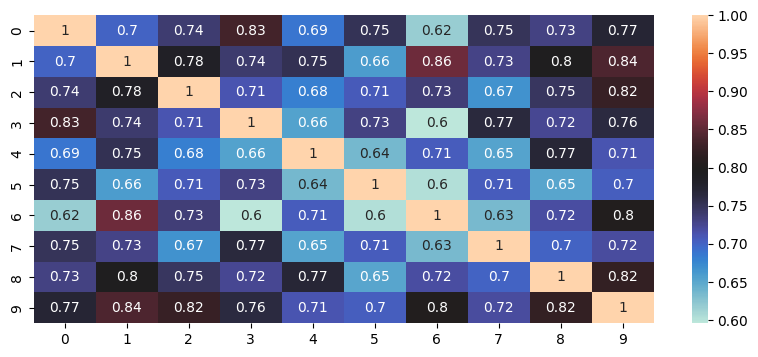

In [49]:
matTNG_cv_red = cosine_similarity(TNG_cv_red[:10])

names = [tnews.target_names[i] for i in tnews.target[:10]]

fig, ax = plt.subplots(figsize=(10,4)) 
sns.heatmap(matTNG_cv_red, annot=True, 
            ax = ax,
            cmap = "icefire")